In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [124]:

# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [ ]:
'''cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)'''

In [8]:
'''# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))'''


Total transactions in train dataset:  396981
Total transactions in test dataset:  93532


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

## Практика

In [3]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
raw_df = raw_df[['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME' , 'amount', 'trx_category', 'target_flag']]
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [5]:
#данные агрегированы по сумме транзакций за исключением MCC, 
#так как позиции отдельных категорий отличаются в зависимостости от агрегирования по сумме или по количеству транзакций
#в колонке тип канала есть значение "неизвестный канал" - отнесем его к отдельной категории
#уберем колонку TRDATETIME и добавим новые колонки день недели и 

In [6]:
#замена значений в типе канала
import math
def drop_nan(inp):
    if inp in ['type1','type2','type3','type4','type5']:
        pass
    else:
        return 'type0'
    
raw_df['channel_type'] = raw_df['channel_type'].apply(drop_nan)
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,type0,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,type0,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,type0,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,type0,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,type0,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [7]:
#добавление столбцов день, час дня, убираем колонку trdatetime
raw_df['hour_of_week'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H'))
raw_df['day_of_week'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%A'))
raw_df = raw_df[['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'amount', 'trx_category', 'day_of_week', 'hour_of_week', 'target_flag']]
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,amount,trx_category,day_of_week,hour_of_week,target_flag
0,01/10/2017,0,5200,type0,810,5023.0,POS,Saturday,00,0
1,01/10/2017,0,6011,type0,810,20000.0,DEPOSIT,Thursday,12,0
2,01/12/2017,0,5921,type0,810,767.0,POS,Tuesday,00,0
3,01/10/2017,0,5411,type0,810,2031.0,POS,Saturday,00,0
4,01/10/2017,0,6012,type0,810,36562.0,C2C_OUT,Tuesday,13,0


In [8]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

get_new_cols = None

for colname in ['PERIOD', 'MCC', 'channel_type', 'currency', 'day_of_week', 'hour_of_week', 'trx_category']:
    if colname == 'PERIOD':
        get_new_cols = get_aggregated_df(df = raw_df, agg_type = 'sum', col_to_groupby = colname)
    elif colname == 'MCC': 
        get_new_cols = pd.concat([get_aggregated_df(df = raw_df, agg_type = 'sum', col_to_groupby = colname), get_new_cols], axis=1)
        get_new_cols = pd.concat([get_aggregated_df(df = raw_df, agg_type = 'count', col_to_groupby = colname), get_new_cols], axis=1)
    else:
        get_new_cols = pd.concat([get_aggregated_df(df = raw_df, agg_type = 'sum', col_to_groupby = colname), get_new_cols], axis=1)
print(get_new_cols.head())



       trx_category_sum_BACK_TRX  trx_category_sum_C2C_IN  \
cl_id                                                       
0                            0.0                      0.0   
1                            0.0                      0.0   
5                        13990.0                      0.0   
9                            0.0                 296950.0   
10                           0.0                  10000.0   

       trx_category_sum_C2C_OUT  trx_category_sum_CASH_ADV  \
cl_id                                                        
0                      36562.00                        0.0   
1                          0.00                        0.0   
5                      33878.38                        0.0   
9                          0.00                        0.0   
10                     21692.90                        0.0   

       trx_category_sum_CAT  trx_category_sum_DEPOSIT  trx_category_sum_POS  \
cl_id                                                     

In [9]:
target_col = raw_df[['cl_id', 'target_flag']].drop_duplicates()
target_col.head() 


,cl_id,target_flag
0,0,0
5,1,0
109,5,1
251,9,0
290,10,0


In [10]:
#объединяем два датафрейма
merged_df = get_new_cols.merge(target_col, how='inner', on='cl_id')
merged_df.head()

,cl_id,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,...,PERIOD_sum_01/07/2017,PERIOD_sum_01/08/2017,PERIOD_sum_01/09/2017,PERIOD_sum_01/10/2016,PERIOD_sum_01/10/2017,PERIOD_sum_01/11/2016,PERIOD_sum_01/11/2017,PERIOD_sum_01/12/2016,PERIOD_sum_01/12/2017,target_flag
0,0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,...,0.00,0.0,0.00,0.0,63616.0,0.0,0.0,0.0,767.0,0
1,1,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,...,53930.26,3807.5,198285.28,0.0,11555.0,0.0,0.0,0.0,0.0,0
2,5,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1
3,9,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,...,251559.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,10,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,...,94454.32,925306.4,104583.27,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
merged_df.set_index(keys='cl_id', inplace=True)
merged_df

,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS,...,PERIOD_sum_01/07/2017,PERIOD_sum_01/08/2017,PERIOD_sum_01/09/2017,PERIOD_sum_01/10/2016,PERIOD_sum_01/10/2017,PERIOD_sum_01/11/2016,PERIOD_sum_01/11/2017,PERIOD_sum_01/12/2016,PERIOD_sum_01/12/2017,target_flag
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,36562.00,0.00,0.00,20000.0,7821.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,63616.00,0.00,0.00,0.00,767.00,0
1,0.00,0.00,0.00,0.00,0.00,95000.0,122578.04,0.0,0.0,50000.0,...,53930.26,3807.50,198285.28,0.0,11555.00,0.00,0.00,0.00,0.00,0
5,13990.00,0.00,33878.38,0.00,0.00,130000.0,290500.75,5500.0,6000.0,66500.0,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1
9,0.00,296950.00,0.00,0.00,0.00,5000.0,12365.09,0.0,100000.0,435000.0,...,251559.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0
10,0.00,10000.00,21692.90,0.00,37694.98,426300.0,200956.11,0.0,5400.0,422300.0,...,94454.32,925306.40,104583.27,0.0,0.00,0.00,0.00,0.00,0.00,0
11,0.00,0.00,0.00,0.00,0.00,182000.0,245747.14,0.0,0.0,0.0,...,189479.89,172543.74,6151.05,0.0,0.00,0.00,0.00,0.00,0.00,0
14,0.00,152700.00,0.00,0.00,0.00,0.0,258990.17,0.0,0.0,37000.0,...,118328.55,31197.08,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1
20,0.00,0.00,0.00,0.00,0.00,215000.0,222308.09,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0
21,2777.00,4001.00,0.00,0.00,0.00,112000.0,220103.65,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,125611.66,0.00,90058.93,0.00,0


In [12]:
#разбиваем данные на test, train
from sklearn.model_selection import train_test_split

y = merged_df['target_flag'].copy()
data_train, data_test, y_train, y_test = train_test_split(get_new_cols, y, test_size=0.2, random_state=42)
y_train.head()

cl_id
8729    1
9593    0
1622    1
7552    0
8670    1
Name: target_flag, dtype: int64

In [14]:
#выбираем колонки для обучения 

x_train = data_train 
#y_train = data_train['target_flag']
x_test = data_test 
#y_test = data_test['target_flag']

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [18]:
import xgboost
from sklearn.metrics import roc_auc_score, roc_curve
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.97
Test:  0.81


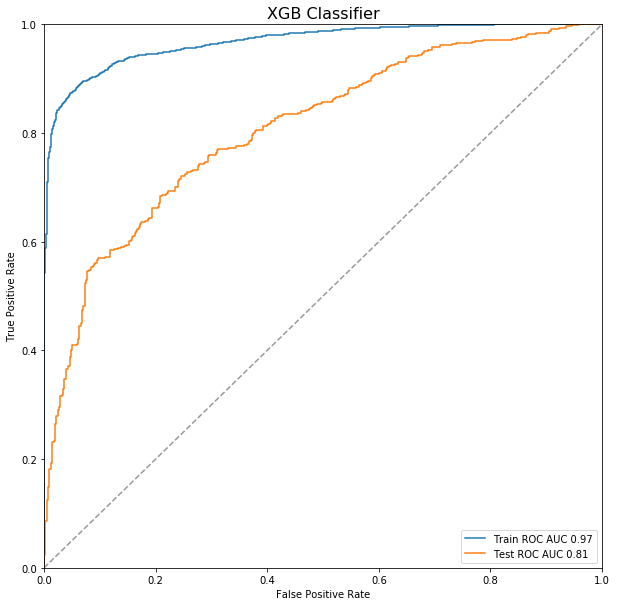

In [19]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

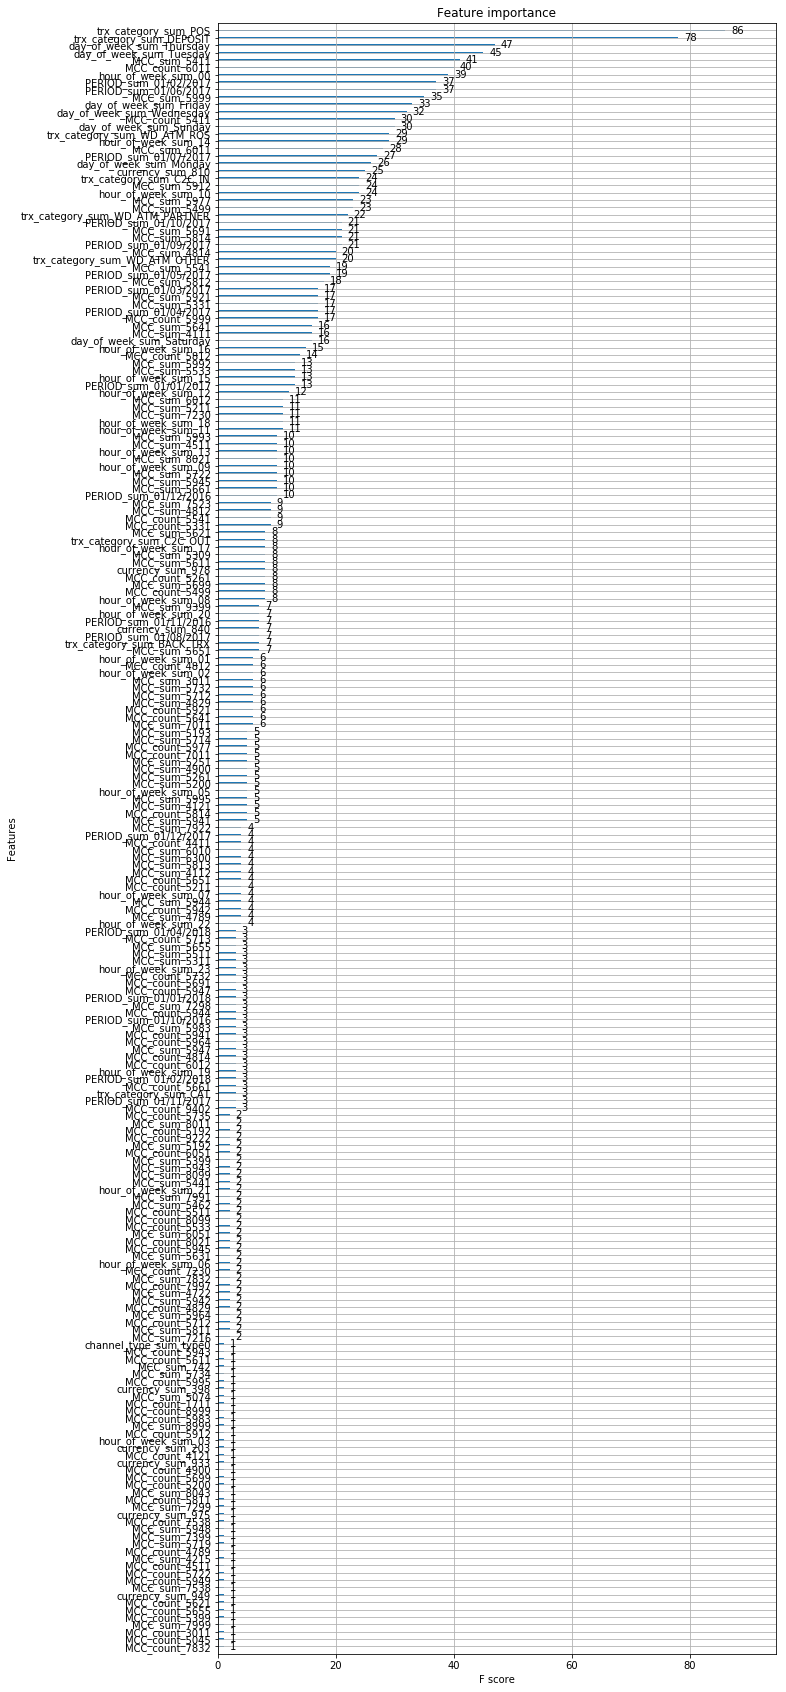

In [23]:
matplotlib.rcParams['figure.figsize'] = (10, 30)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')

In [108]:
#распределение значений по категориям 
for col in raw_df.columns.values:
    if col in ["cl_id", "amount", "target_sum"]:
        continue
    print(col,'\n',raw_df[col].value_counts().head(30),'\n')

PERIOD 
 01/07/2017    55757
01/06/2017    54082
01/05/2017    46492
01/08/2017    46245
01/12/2016    45788
01/01/2017    44254
01/04/2017    42952
01/02/2017    37309
01/03/2017    35068
01/09/2017    27796
01/11/2016    20923
01/10/2017    11370
01/11/2017     5368
01/12/2017     5041
01/10/2016     3694
01/01/2018     3397
01/02/2018     2765
01/03/2018     2175
01/04/2018       37
Name: PERIOD, dtype: int64 

MCC 
 5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
5541     19816
5912     18728
5999     13073
6012     10056
5921      8578
5331      7641
4121      6266
5211      6262
4829      6205
5691      5161
5261      4803
4111      4362
5977      4300
5200      3460
5732      3271
5311      3258
5533      2946
5651      2915
4812      2857
5641      2710
8099      2674
5722      2667
5661      2601
8999      2599
5941      2597
5945      2461
7011      2430
4814      2416
5712      2415
7832      1987
7230      1862
4112      1854
5813      1844
5964  

In [104]:
raw_df['day_of_week'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%A'))
amount_by_hour_count_df = raw_df.groupby('day_of_week').sum().reset_index()
amount_by_hour_count_df['amount'] = amount_by_hour_count_df['amount'].apply(lambda x: round(x))
amount_by_hour_count_df[['day_of_week', 'amount']].sort_values(by='amount', ascending=False)

,day_of_week,amount
0,Friday,488955196
6,Wednesday,453220651
4,Thursday,446491153
5,Tuesday,409852832
1,Monday,398655955
2,Saturday,347622783
3,Sunday,262698921


In [120]:

raw_df['hour_of_week'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H'))
amount_by_hour_count_df = raw_df.groupby('hour_of_week').sum().reset_index()
amount_by_hour_count_df['amount'] = amount_by_hour_count_df['amount'].apply(lambda x: round(x))
amount_by_hour_count_df[['hour_of_week', 'amount']].sort_values(by='amount', ascending=False)


,hour_of_week,amount
0,00,1486147085
13,13,112044687
12,12,110975728
11,11,108598222
14,14,104497020
15,15,100970275
10,10,94322752
17,17,91628880
16,16,88716866
18,18,84603185


In [116]:
amount_by_mcc_count_df = raw_df.groupby('MCC').sum().sort_values(by='amount', ascending=False).reset_index()
amount_by_mcc_count_df['amount'] = amount_by_mcc_count_df['amount'].apply(lambda x: round(x))
amount_by_mcc_count_df[['MCC', 'amount']].head(30)

,MCC,amount
0,6011,1493999791
1,6012,184927463
2,5411,134670038
3,7011,94424523
4,4829,89628407
5,5812,53413988
6,4722,42771836
7,5712,31082848
8,5211,30597995
9,4511,28753671


In [117]:
amount_by_mcc_count_df = raw_df.groupby('trx_category').sum().sort_values(by='amount', ascending=False).reset_index()
amount_by_mcc_count_df['amount'] = amount_by_mcc_count_df['amount'].apply(lambda x: round(x))
amount_by_mcc_count_df[['trx_category', 'amount']].head(30)


,trx_category,amount
0,POS,1013061837
1,WD_ATM_ROS,668084500
2,DEPOSIT,482745896
3,WD_ATM_PARTNER,332717750
4,C2C_IN,99897150
5,C2C_OUT,88074879
6,WD_ATM_OTHER,74780621
7,BACK_TRX,24619174
8,CAT,22602860
9,CASH_ADV,912825


In [118]:
amount_by_mcc_count_df = raw_df.groupby('currency').sum().sort_values(by='amount', ascending=False).reset_index()
amount_by_mcc_count_df['amount'] = amount_by_mcc_count_df['amount'].apply(lambda x: round(x))
amount_by_mcc_count_df[['currency', 'amount']].head(30)

,currency,amount
0,810,2572996460
1,704,136717976
2,360,71935553
3,410,12609420
4,392,1710582
5,51,1565529
6,348,1382239
7,764,1354299
8,144,1079799
9,398,1025721


### Агрегирование с помощью SQL

In [14]:
import sqlite3
conn = sqlite3.connect('transactions.db')

In [15]:
raw_df.to_sql('transactions_raw', if_exists='replace', con=conn)

In [16]:
check = pd.io.sql.read_sql("""
    select * from transactions_raw limit 100
    """, conn
)

In [17]:
pd.io.sql.read_sql("""
    select count(*), count(distinct cl_id) from transactions_raw
    """, conn
)

,count(*),count(distinct cl_id)
0,490513,5000


In [18]:
MCC_list = raw_df.MCC.value_counts().head(20).index.tolist()
for MCC_code in MCC_list:
    print(
        'sum(case when MCC = {0} then amount else 0 end) as MCC_{0},'.format(MCC_code)
    )

sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
sum(case when MCC = 5499 then amount else 0 end) as MCC_5499,
sum(case when MCC = 5541 then amount else 0 end) as MCC_5541,
sum(case when MCC = 5912 then amount else 0 end) as MCC_5912,
sum(case when MCC = 5999 then amount else 0 end) as MCC_5999,
sum(case when MCC = 6012 then amount else 0 end) as MCC_6012,
sum(case when MCC = 5921 then amount else 0 end) as MCC_5921,
sum(case when MCC = 5331 then amount else 0 end) as MCC_5331,
sum(case when MCC = 4121 then amount else 0 end) as MCC_4121,
sum(case when MCC = 5211 then amount else 0 end) as MCC_5211,
sum(case when MCC = 4829 then amount else 0 end) as MCC_4829,
sum(case when MCC = 5691 then amount else 0 end) as MCC_5691,
sum(case when MCC = 5261 then amount else 0 end) as MCC_5261,
sum(case

In [19]:
datamart_check = pd.io.sql.read_sql("""
    select
        cl_id,
        target_flag,
        sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
        sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
        sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
        sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
        sum(case when MCC = 5499 then amount else 0 end) as MCC_5499,

/*------------------average amount---------------------------------*/
        avg(case when MCC = 5411 then amount else 0 end) as MCC_5411_avg,
        avg(case when MCC = 6011 then amount else 0 end) as MCC_6011_avg,
        avg(case when MCC = 5814 then amount else 0 end) as MCC_5814_avg,
        avg(case when MCC = 5812 then amount else 0 end) as MCC_5812_avg,
        avg(case when MCC = 5499 then amount else 0 end) as MCC_5499_avg
    from transactions_raw
    group by 1, 2
    order by 1
    """, conn)

In [20]:
datamart_check

,cl_id,target_flag,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_5411_avg,MCC_6011_avg,MCC_5814_avg,MCC_5812_avg,MCC_5499_avg
0,0,0,2031.00,20000.0,0.00,0.00,0.00,406.200000,4000.000000,0.000000,0.000000,0.000000
1,1,0,14629.46,145000.0,82441.17,3180.01,492.80,140.667885,1394.230769,792.703558,30.577019,4.738462
2,5,1,44925.40,208000.0,247.00,3309.00,7196.70,316.376056,1464.788732,1.739437,23.302817,50.680986
3,9,0,39.00,540000.0,0.00,0.00,0.00,1.000000,13846.153846,0.000000,0.000000,0.000000
4,10,0,53920.36,854000.0,2010.00,319.00,13225.02,116.458661,1844.492441,4.341253,0.688985,28.563758
5,11,0,31084.62,182000.0,5653.00,11814.80,383.60,143.247097,838.709677,26.050691,54.446083,1.767742
6,14,1,20408.96,37000.0,23894.06,5659.00,827.00,150.065882,272.058824,175.691618,41.610294,6.080882
7,20,0,9834.43,215000.0,0.00,3023.33,1247.73,127.719870,2792.207792,0.000000,39.264026,16.204286
8,21,0,25978.04,65000.0,4853.00,7540.00,1277.45,209.500323,524.193548,39.137097,60.806452,10.302016
9,22,0,241.82,139000.0,0.00,0.00,2610.00,4.098644,2355.932203,0.000000,0.000000,44.237288


### Агрегирование с помощью Pandas